In [1]:
# %pip install scikit-learn
#%pip install Prophet

import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import plot_importance
import matplotlib.pyplot as plt


In [2]:
sales_file="../../Data/brand details last 1 year.xlsx"
sales_data=pd.read_excel(sales_file,sheet_name='Healthkart')
sales_data['SKU_grouped']=sales_data['SKU Name'].str.split(',',expand=True)[0]
sales_data

,Order Date & Time,Brand Name,SKU Name,Quantity,Item Value,Delivery Pincode,Payment Type,SKU_grouped
0,2023-10-28 07:34:26,HEALTHKART,"MuscleBlaze Limited Edition Shubman Shaker, B...",1,699.0,201306,PREPAID,MuscleBlaze Limited Edition Shubman Shaker
1,2023-10-28 07:34:26,HEALTHKART,"MuscleBlaze High Protein Muesli, 0.4 kg Dark...",1,399.0,201309,COD,MuscleBlaze High Protein Muesli
2,2023-10-28 07:34:27,HEALTHKART,"MuscleBlaze High Protein Gold Gainer, 2.2 lb ...",1,2129.0,201301,PREPAID,MuscleBlaze High Protein Gold Gainer
3,2023-10-28 07:34:27,HEALTHKART,HK Vitals ProteinUp Active Strength & Energy b...,1,799.0,201303,PREPAID,HK Vitals ProteinUp Active Strength & Energy b...
4,2023-10-28 07:34:28,HEALTHKART,"MuscleBlaze Biozyme Performance Whey, 4.4 lb ...",1,5499.0,201301,PREPAID,MuscleBlaze Biozyme Performance Whey
...,...,...,...,...,...,...,...,...
104421,2024-10-28 14:52:06,HEALTHKART,"Supermilk Height+Â for Boy/Girl 4 to 7 years, ...",1,1348.0,110092,PREPAID,Supermilk Height+Â for Boy/Girl 4 to 7 years
104422,2024-10-28 14:57:39,HEALTHKART,"HealthKart HK Vitals Skin Radiance Collagen, ...",1,1748.0,201304,COD,HealthKart HK Vitals Skin Radiance Collagen
104423,2024-10-28 15:06:14,healthkart,"MuscleBlaze T-Surge Black, 90 tablet(s) Unfl...",1,1399.0,121005,COD,MuscleBlaze T-Surge Black
104424,2024-10-28 15:10:41,healthkart,"HealthKart HK Vitals Skin Radiance Collagen, ...",1,1099.0,110081,COD,HealthKart HK Vitals Skin Radiance Collagen


In [3]:
sales_data['SKU Name']=sales_data['SKU Name'].str.split('_')
sales_data=sales_data.explode('SKU Name',ignore_index=True)
sales_data['SKU_grouped']=sales_data['SKU Name'].str.split(',',expand=True)[0]
sales_data['Order Date & Time']=pd.to_datetime(sales_data['Order Date & Time'])
sales_data['Date']=sales_data['Order Date & Time'].dt.date
sales_data_grouped=sales_data.groupby(['SKU_grouped','Date']).agg({'Quantity':'sum',"Item Value":"sum","Brand Name":"first"}).reset_index()
sales_data_grouped=sales_data_grouped.sort_values('Date') 
sales_data_grouped_select=sales_data.groupby(['SKU_grouped']).agg({'Item Value':'sum',"Date":'nunique'}).reset_index()

sales_data_grouped_select=sales_data_grouped_select.rename(columns={'Item Value': 'Total Sales Value',"Date":'Date Count'})
sales_data_grouped_select=sales_data_grouped_select.sort_values(by=['Date Count'],ascending=[False])
sales_data_grouped_select=sales_data_grouped_select.head(20)
sales_data_grouped_select=sales_data_grouped_select.merge(sales_data_grouped,on='SKU_grouped',how='left')
sales_data_grouped_select

,SKU_grouped,Total Sales Value,Date Count,Date,Quantity,Item Value,Brand Name
0,MuscleBlaze Biozyme Performance Whey,55034952.0,363,2023-10-28,18,80332.0,HEALTHKART
1,MuscleBlaze Biozyme Performance Whey,55034952.0,363,2023-10-29,19,83021.0,HEALTHKART
2,MuscleBlaze Biozyme Performance Whey,55034952.0,363,2023-10-30,16,77434.0,HEALTHKART
3,MuscleBlaze Biozyme Performance Whey,55034952.0,363,2023-10-31,24,90166.0,HEALTHKART
4,MuscleBlaze Biozyme Performance Whey,55034952.0,363,2023-11-01,5,15765.0,HEALTHKART
...,...,...,...,...,...,...,...
6653,MuscleBlaze Liquid L-Carnitine,1219420.0,298,2024-10-20,2,1598.0,HEALTHKART
6654,MuscleBlaze Liquid L-Carnitine,1219420.0,298,2024-10-21,4,8191.0,healthkart
6655,MuscleBlaze Liquid L-Carnitine,1219420.0,298,2024-10-22,1,1748.0,HEALTHKART
6656,MuscleBlaze Liquid L-Carnitine,1219420.0,298,2024-10-25,1,5097.0,HEALTHKART


In [4]:
sales_data_grouped_select[sales_data_grouped_select['SKU_grouped']=="MuscleBlaze Biozyme Performance Whey"].shape

(363, 7)

In [5]:
sales_data_grouped_select=sales_data_grouped_select.sort_values('Date')
sales_data_grouped_select["SKU_grouped"].nunique()

20

In [6]:

# Define date range
start_date = datetime(2023, 1, 1)
end_date = datetime(2025, 11, 30)

# Generate daily dates
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Define Indian holidays including Dussehra and Black Friday
indian_holidays = {
    '2023-01-26': 'Republic Day',
    '2023-08-15': 'Independence Day',
    '2023-10-24': 'Dussehra',
    '2023-10-02': 'Gandhi Jayanti',
    '2023-11-12': 'Diwali',
    '2023-11-24': 'Black Friday',
    '2023-12-25': 'Chrismas',
    '2024-01-26': 'Republic Day',
    '2024-08-15': 'Independence Day',
    '2024-10-13': 'Dussehra',
    '2024-10-02': 'Gandhi Jayanti',
    '2024-11-01': 'Diwali',
    '2024-11-29': 'Black Friday',
    '2024-12-25': 'Chrismas',
    '2025-01-26': 'Republic Day',
    '2025-08-15': 'Independence Day',
    '2025-10-02': 'Gandhi Jayanti',
    '2025-10-02': 'Gandhi Jayanti',
    '2025-10-21': 'Dussehra',
    '2025-10-20': 'Diwali',
    '2025-11-28': 'Black Friday',
    '2025-12-25': 'Chrismas'
}

# Create a date_mapFrame
date_map = pd.DataFrame({'Date': dates})

# Add columns
date_map['Year'] = date_map['Date'].dt.year                       # Extract year
date_map['Week of Year'] = date_map['Date'].dt.isocalendar().week  # ISO week number
# add week of month also
date_map['Week of Month'] = (date_map['Date'].dt.day-1) // 7 + 1
date_map['Day of Week'] = date_map['Date'].dt.day_name()          # Day name (e.g., Sunday, Monday)
date_map['Week Ending Date'] = date_map['Date'] + pd.offsets.Week(weekday=5)  # Saturday as week-ending date

# Add holiday names
date_map['Holiday Name'] = date_map['Date'].dt.strftime('%Y-%m-%d').map(indian_holidays)

# Add a column to mark whether the date is a holiday or weekend
date_map['Is Weekend'] = np.where(date_map['Day of Week'].isin(['Saturday', 'Sunday']),1,0)
date_map['Is Holiday'] = date_map['Holiday Name'].notna().astype(int)

# add day of year
date_map['Day of Year'] = date_map['Date'].dt.dayofyear

In [7]:
sales_data_grouped_select['Date']=pd.to_datetime(sales_data_grouped_select['Date'])

In [8]:
#Merge festival data with SKU demand data
unique_skus=sales_data_grouped_select['SKU_grouped'].unique()
date_map=date_map[["Date","Year","Week of Year",'Day of Year',"Week of Month","Is Weekend","Is Holiday"]]
date_map['Date'] = pd.to_datetime(date_map['Date'])
sales_data_grouped_select['Date'] = pd.to_datetime(sales_data_grouped_select['Date'])
final_df = pd.DataFrame()
for sku in  unique_skus:
    main_df=sales_data_grouped_select[sales_data_grouped_select['SKU_grouped']==sku]
    start_date=min(main_df['Date'])
    end_date=max(main_df['Date'])
    #print(start_date)
    #print(end_date)
    SKU_df = date_map[(date_map['Date'] >= start_date) & (date_map['Date'] <= end_date)]
    SKU_df=SKU_df.merge(main_df,how='left',on='Date')
    SKU_df['SKU_grouped'] = SKU_df['SKU_grouped'].fillna(method='ffill') 
    SKU_df['Quantity'] = SKU_df['Quantity'].fillna(0) 
    final_df=pd.concat([final_df, SKU_df], ignore_index=True)
 #sales_data_grouped_select=   
#sales_data_grouped_select=sales_data_grouped_select.merge(date_map[["Date","Year","Week of Year",'Day of Year',"Week of Month","Is Weekend","Is Holiday"]],on='Date',how='left')
# sales_data_grouped_select['is_festival']=sales_data_grouped_select['is_festival'].fillna(0).astype(int)
print(sales_data_grouped_select.shape)
sales_data_grouped_select=final_df.copy()
final_df.to_clipboard(index=False)

C:\Users\dimpl\AppData\Local\Temp\ipykernel_9148\2150556445.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  SKU_df['SKU_grouped'] = SKU_df['SKU_grouped'].fillna(method='ffill')
C:\Users\dimpl\AppData\Local\Temp\ipykernel_9148\2150556445.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  SKU_df['SKU_grouped'] = SKU_df['SKU_grouped'].fillna(method='ffill')
C:\Users\dimpl\AppData\Local\Temp\ipykernel_9148\2150556445.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  SKU_df['SKU_grouped'] = SKU_df['SKU_grouped'].fillna(method='ffill')
C:\Users\dimpl\AppData\Local\Temp\ipykernel_9148\2150556445.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfil

(6658, 7)


In [9]:
#Add 14 days before festival
sales_data_grouped_select['is_14_days_before_holiday']=0
for date in date_map[date_map['Is Holiday']==1]["Date"].unique():
    sales_data_grouped_select.loc[
        (sales_data_grouped_select['Date']>=date - pd.Timedelta(days=14)) & (sales_data_grouped_select['Date']<date),
         'is_14_days_before_festival']=1 

#Add 7 days before festival
sales_data_grouped_select['is_7_days_before_holiday']=0
for date in date_map[date_map['Is Holiday']==1]["Date"].unique():
    sales_data_grouped_select.loc[
        (sales_data_grouped_select['Date']>=date-pd.Timedelta(days=7)) & (sales_data_grouped_select['Date']<date),
         'is_7_days_before_festival']=1 


#Lag features
for lag in [1,7,14]:
    sales_data_grouped_select[f'demand_lag_{lag}']=sales_data_grouped_select.groupby('SKU_grouped')['Quantity'].shift(lag)


In [10]:
sales_data_grouped_select.columns

Index(['Date', 'Year', 'Week of Year', 'Day of Year', 'Week of Month',
       'Is Weekend', 'Is Holiday', 'SKU_grouped', 'Total Sales Value',
       'Date Count', 'Quantity', 'Item Value', 'Brand Name',
       'is_14_days_before_holiday', 'is_14_days_before_festival',
       'is_7_days_before_holiday', 'is_7_days_before_festival', 'demand_lag_1',
       'demand_lag_7', 'demand_lag_14'],
      dtype='object')

In [11]:
sales_data_grouped_select.fillna(0,inplace=True)
sales_data_grouped_select.isna().sum()

Date                          0
Year                          0
Week of Year                  0
Day of Year                   0
Week of Month                 0
Is Weekend                    0
Is Holiday                    0
SKU_grouped                   0
Total Sales Value             0
Date Count                    0
Quantity                      0
Item Value                    0
Brand Name                    0
is_14_days_before_holiday     0
is_14_days_before_festival    0
is_7_days_before_holiday      0
is_7_days_before_festival     0
demand_lag_1                  0
demand_lag_7                  0
demand_lag_14                 0
dtype: int64

In [12]:
#Add rolling statics
sales_data_grouped_select['rolling mean 7']=sales_data_grouped_select.groupby('SKU_grouped')['Quantity'].shift(1).rolling(window=7).mean()
sales_data_grouped_select['rolling std 7']=sales_data_grouped_select.groupby('SKU_grouped')['Quantity'].shift(1).rolling(window=7).std()
sales_data_grouped_select['Date']=pd.to_datetime(sales_data_grouped_select['Date'])
sales_data_grouped_select['day of week']=sales_data_grouped_select['Date'].dt.dayofweek
sales_data_grouped_select['day of month']=sales_data_grouped_select['Date'].dt.month
print(sales_data_grouped_select[sales_data_grouped_select['SKU_grouped']=="MuscleBlaze Biozyme Performance Whey"].shape)
sales_data_grouped_select.fillna(0,inplace=True)
print(sales_data_grouped_select[sales_data_grouped_select['SKU_grouped']=="MuscleBlaze Biozyme Performance Whey"].shape)
sales_data_grouped_select.head()

(367, 24)
(367, 24)


,Date,Year,Week of Year,Day of Year,Week of Month,Is Weekend,Is Holiday,SKU_grouped,Total Sales Value,Date Count,...,is_14_days_before_festival,is_7_days_before_holiday,is_7_days_before_festival,demand_lag_1,demand_lag_7,demand_lag_14,rolling mean 7,rolling std 7,day of week,day of month
0,2023-10-28,2023,43,301,4,1,0,MuscleBlaze Biozyme Performance Whey,55034952.0,363.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,5,10
1,2023-10-29,2023,43,302,5,1,0,MuscleBlaze Biozyme Performance Whey,55034952.0,363.0,...,1.0,0,0.0,18.0,0.0,0.0,0.0,0.0,6,10
2,2023-10-30,2023,44,303,5,0,0,MuscleBlaze Biozyme Performance Whey,55034952.0,363.0,...,1.0,0,0.0,19.0,0.0,0.0,0.0,0.0,0,10
3,2023-10-31,2023,44,304,5,0,0,MuscleBlaze Biozyme Performance Whey,55034952.0,363.0,...,1.0,0,0.0,16.0,0.0,0.0,0.0,0.0,1,10
4,2023-11-01,2023,44,305,1,0,0,MuscleBlaze Biozyme Performance Whey,55034952.0,363.0,...,1.0,0,0.0,24.0,0.0,0.0,0.0,0.0,2,11


In [13]:
sales_data_grouped_select.isna().sum()

Date                          0
Year                          0
Week of Year                  0
Day of Year                   0
Week of Month                 0
Is Weekend                    0
Is Holiday                    0
SKU_grouped                   0
Total Sales Value             0
Date Count                    0
Quantity                      0
Item Value                    0
Brand Name                    0
is_14_days_before_holiday     0
is_14_days_before_festival    0
is_7_days_before_holiday      0
is_7_days_before_festival     0
demand_lag_1                  0
demand_lag_7                  0
demand_lag_14                 0
rolling mean 7                0
rolling std 7                 0
day of week                   0
day of month                  0
dtype: int64

In [14]:
def wmape(y_true, y_pred):
    if np.sum(y_true) == 0:
        return 0
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

In [15]:
unique_skus=sales_data_grouped_select['SKU_grouped'].unique()
results={}

In [16]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [17]:
# %pip install scikit-learn
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
# remove all warning messages
import warnings
warnings.filterwarnings("ignore")
# remove cmdstanpy warning for prophet
import logging
logger = logging.getLogger('cmdstanpy')
logger.propagate = False
logger.setLevel(logging.ERROR)


In [18]:
def xgb_forecast(train_df,test_df,forecasting_horizon,model_features):
    print("Inside xgb_Model")
    param_grid={"n_estimators":[25,75,50,100,150],
                "learning_rate":[0.01,0.05],
                "max_depth":[3,5,4,7]}
    train_data=train_df.copy()
    test_data=test_df.copy()

    Model_features=[str(col).replace(']','').replace('[','').replace('<','').replace('>','') for col in model_features]
    wmape_scorer=make_scorer(wmape,greater_is_better=False)
    model=XGBRegressor(objective='reg:squarederror')
    X_train=train_data[Model_features]
    y_train=train_data['Quantity']
    model.fit(X_train,y_train)

    # Use gridsearchCV for hyperparameter tuning
    grid_search=GridSearchCV(model,param_grid=param_grid,scoring=wmape_scorer,cv=5)
    grid_search.fit(X_train,y_train)

    # Get the best model
    best_model=grid_search.best_estimator_
    best_model.fit(X_train,y_train)
    train_predictions=best_model.predict(X_train)
    test_predictions=best_model.predict(test_data[Model_features])

    train_wmape=wmape(y_train,train_predictions)
    test_wmape=wmape(test_data['Quantity'],test_predictions)

    train_data['Prediction']=train_predictions
    test_data['Prediction']=test_predictions

    combined_data=pd.concat([train_data,test_data],axis=0)
    return combined_data[["SKU_grouped","Date","Quantity","Prediction"]],train_wmape,test_wmape,best_model

params_grid={
            "seasonality_mode":("multiplicative","additive"),
            "changepoint_prior_scale":[0.1,0.3,0.5,0.7],
            "seasonality_prior_scale":[1.0,5.0,10.0],
            "n_changepoints":[25,35,50]

}
grid= ParameterGrid(params_grid)


def multivariate_prophet(train_df, test_df, forecasting_horizon, model_features):
    print("Inside multivariate_prophet")
    model_parameters=pd.DataFrame(columns=["WMAPE","Parameters"])
    train_data=train_df.copy()
    test_data=test_df.copy()
    train_data=train_data.rename(columns={"Date":"ds","Quantity":"y"})
    test_data=test_data.rename(columns={"Date":"ds","Quantity":"y"})
    Model_features=[str(col).replace(']','').replace('[','').replace('<','').replace('>','') for col in model_features]
    for p in grid:
        prophet_model=Prophet(changepoint_prior_scale = p["changepoint_prior_scale"],
                              n_changepoints=p["n_changepoints"],
                                seasonality_mode=p["seasonality_mode"],
                                seasonality_prior_scale=p["seasonality_prior_scale"])
        
        for reg in model_features:
            prophet_model.add_regressor(reg)

        prophet_model.add_country_holidays(country_name='IN')
        prophet_model.fit(train_data)
        future_dates=pd.date_range(start=train_df["Date"].max()+timedelta(days=1),periods=30,freq='D')
        future = pd.DataFrame({"ds": future_dates})
        for col in model_features:
            future[col] = test_df[col].values

        prophet_forecast=prophet_model.predict(future)
        test_predictions = prophet_forecast.loc[prophet_forecast['ds'].isin(test_df['Date'])]['yhat']

        WMAPE = wmape(test_df['Quantity'], test_predictions.values)

        x=pd.DataFrame({"WMAPE":WMAPE,"Parameters":[p]})
        model_parameters=pd.concat([model_parameters,x],ignore_index=False)

    params = model_parameters[model_parameters['WMAPE']==model_parameters['WMAPE'].min()]['Parameters'].values[0]

    model = Prophet(changepoint_prior_scale = params["changepoint_prior_scale"],
                    n_changepoints=params["n_changepoints"],
                    seasonality_mode=params["seasonality_mode"],
                    seasonality_prior_scale=params["seasonality_prior_scale"],
                    interval_width=0.95)
    for col in model_features:
        model.add_regressor(col)

    model.fit(train_data)

    future = model.make_future_dataframe(periods=30, freq='D')
    for col in model_features:
        future[col] = pd.concat([train_df,test_df])[col].values
    forecast = model.predict(future)
    train_wmape = wmape(train_data['y'], model.predict(train_data)['yhat'])
    test_wmape = wmape(test_data['y'], forecast["yhat"].tail(forecasting_horizon))
    train_data['Prediction'] = model.predict(train_data)['yhat'].values
    train_data["Set"]="Train"

    test_data['Prediction']=forecast["yhat"].tail(forecasting_horizon).values
    test_data["Set"]="Test"

    combined_data=pd.concat([train_data,test_data],axis=0)
    combined_data['SKU_grouped']=sku
    combined_data.rename(columns={"ds":"Date","y":"Quantity"},inplace=True)
    return combined_data[["SKU_grouped","Date","Quantity","Prediction"]],train_wmape,test_wmape,model

def multi_prophet_forecasting(main_df, test_df, prophet_model, model_features, forecasting_horizon=60):
    print("Inside multi_prophet_forecasting")
    future_dates=pd.date_range(start=test_df["Date"].max()+timedelta(days=1),periods=forecasting_horizon,freq='D')
    future=pd.DataFrame({"ds":future_dates})
    future['Year'] = future['ds'].dt.year                       # Extract year
    future['Week of Year'] = future['ds'].dt.isocalendar().week  # ISO week number
    # add week of month also
    future['Week of Month'] = (future['ds'].dt.day-1) // 7 + 1
    # Add Is Weekend flag
    future['Day of Week'] = future['ds'].dt.day_name()          # Day name (e.g., Sunday, Monday)

    # add day of Year
    future['Day of Year'] = future['ds'].dt.dayofyear
    future['Week Ending Date'] = future['ds'] + pd.offsets.Week(weekday=5)  # Saturday as week-ending date
    # Add holiday names
    future['Holiday Name'] = future['ds'].dt.strftime('%Y-%m-%d').map(indian_holidays)
    # Add a column to mark whether the date is a holiday or weekend
    future['Is Weekend'] = np.where(future['Day of Week'].isin(['Saturday', 'Sunday']),1,0)
    future['Is Holiday'] = future['Holiday Name'].notna().astype(int)
    future['is_14_days_before_holiday']=0
    for date in date_map[date_map['Is Holiday']==1]["Date"].unique():
        future.loc[
            (future['ds']>=date - pd.Timedelta(days=14)) & (future['ds']<date),
            'is_14_days_before_festival']=1
    future['is_7_days_before_holiday']=0
    for date in date_map[date_map['Is Holiday']==1]["Date"].unique():
        future.loc[
            (future['ds']>=date-pd.Timedelta(days=7)) & (future['ds']<date),
            'is_7_days_before_festival']=1
    date_map
    # add demand lag 7 by taking values from last year and merging it by week of year
    future=future.merge(main_df[['Day of Year','demand_lag_7','demand_lag_1','demand_lag_14','rolling mean 7','rolling std 7']].drop_duplicates(),on=['Day of Year'],how='left')
    future['day of week']=future['ds'].dt.dayofweek
    future['day of month']=future['ds'].dt.month
    future.fillna(0,inplace=True)
    future['Week of Year'] = future['Week of Year'].astype(int)
    future['Prediction']=prophet_model.predict(future)["yhat"]
    future["Quantity"]=np.nan
    future['SKU_grouped']=sku
    future['Date']=future['ds']
    return future[["SKU_grouped","Date","Prediction"]]


def xgb_forecaster(main_df,test_df, xgb_model, model_features, forecasting_horizon=60):   
    print("Inside xgb_forecaster") 
    future_dates=pd.date_range(start=test_df["Date"].max()+timedelta(days=1),periods=forecasting_horizon,freq='D')
    future=pd.DataFrame({"Date":future_dates})

    future['Year'] = future['Date'].dt.year                       # Extract year
    future['Week of Year'] = future['Date'].dt.isocalendar().week  # ISO week number
    # add week of month also
    future['Week of Month'] = (future['Date'].dt.day-1) // 7 + 1
    # Add Is Weekend flag
    future['Day of Week'] = future['Date'].dt.day_name()          # Day name (e.g., Sunday, Monday)
    # add day of Year
    future['Day of Year'] = future['Date'].dt.dayofyear
    future['Week Ending Date'] = future['Date'] + pd.offsets.Week(weekday=5)  # Saturday as week-ending date
    # Add holiday names
    future['Holiday Name'] = future['Date'].dt.strftime('%Y-%m-%d').map(indian_holidays)
    # Add a column to mark whether the date is a holiday or weekend
    future['Is Weekend'] = np.where(future['Day of Week'].isin(['Saturday', 'Sunday']),1,0)
    future['Is Holiday'] = future['Holiday Name'].notna().astype(int)
    future['is_14_days_before_holiday']=0
    for date in date_map[date_map['Is Holiday']==1]["Date"].unique():
        future.loc[
            (future['Date']>=date - pd.Timedelta(days=14)) & (future['Date']<date),
            'is_14_days_before_festival']=1
    future['is_7_days_before_holiday']=0
    for date in date_map[date_map['Is Holiday']==1]["Date"].unique():
        future.loc[
            (future['Date']>=date-pd.Timedelta(days=7)) & (future['Date']<date),
            'is_7_days_before_festival']=1

    # add demand lag 7 by taking values from last year and merging it by week of year
    future=future.merge(main_df[['Day of Year','demand_lag_7','demand_lag_1','demand_lag_14','rolling mean 7','rolling std 7']].drop_duplicates(),on=['Day of Year'],how='left')


    future['day of week']=future['Date'].dt.dayofweek
    future['day of month']=future['Date'].dt.month
    future.fillna(0,inplace=True)
    future['Prediction']=xgb_model.predict(future[model_features])
    future["Quantity"]=np.nan
    future['SKU_grouped']=sku
    return future
    #return future[["SKU_grouped","Date","Prediction"]]


In [ ]:
forecast_df=pd.DataFrame()

results=pd.DataFrame(columns=['SKU','Model','Train WMAPE','Test WMAPE'])
for sku in unique_skus:
    print(f'Forecasting for SKU:{sku}')
    
    main_df=sales_data_grouped_select[sales_data_grouped_select['SKU_grouped']==sku]
    
    max_date=main_df['Date'].max()
    max_train_date=main_df['Date'].max()-timedelta(days=30)
    main_df['Week of Year'] = main_df['Week of Year'].astype(int)
    train_df=main_df[main_df['Date']<=max_train_date]
    test_df=main_df[main_df['Date']>max_train_date]

    model_features=["Year",'Week of Year', 'Week of Month', 'Is Weekend', 'Is Holiday',
       'is_14_days_before_holiday', 'is_14_days_before_festival',
       'is_7_days_before_holiday', 'is_7_days_before_festival', 'demand_lag_1',
       'demand_lag_7', 'demand_lag_14', 'rolling mean 7', 'rolling std 7',
       'day of week', 'day of month']
    combined_data_xgb,train_wmape,test_wmape,xgb_model=xgb_forecast(train_df,test_df,30,model_features)
    future=xgb_forecaster(main_df,test_df,xgb_model,model_features,60)
    results.loc[len(results)] = [sku, "XGBoost", train_wmape, test_wmape]
    sku_df_xgb=pd.concat([combined_data_xgb,future])
    sku_df_xgb["Train_wmape"]=train_wmape
    sku_df_xgb["Test_wmape"]=test_wmape
    sku_df_xgb["Model"]="XGBoost"
    print(f'WMAPE for {sku}:{train_wmape} (train) and {test_wmape} (test)')
    #combined_data_prophet,train_wmape,test_wmape,prophet_model=multivariate_prophet(train_df,test_df,30,model_features)
    #future=multi_prophet_forecasting(main_df,test_df,prophet_model,model_features,60)
    #results.loc[len(results)] = [sku, "Prophet", train_wmape, test_wmape]
    #sku_df=pd.concat([combined_data_prophet,future])
    #sku_df["Train_wmape"]=train_wmape
    #sku_df["Test_wmape"]=test_wmape
    #sku_df["Model"]="Prophet"
    #print(f'WMAPE for {sku}:{train_wmape} (train) and {test_wmape} (test)')
    forecast_df=pd.concat([forecast_df,sku_df_xgb],axis=0)
    #forecast_df=pd.concat([forecast_df,sku_df],axis=0)


Forecasting for SKU:MuscleBlaze Biozyme Performance Whey
Inside xgb_Model
Inside xgb_forecaster
WMAPE for MuscleBlaze Biozyme Performance Whey:0.20068086416908432 (train) and 0.27659275348369894 (test)
Forecasting for SKU:MuscleBlaze Chocolate Peanut Butter
Inside xgb_Model
Inside xgb_forecaster
WMAPE for MuscleBlaze Chocolate Peanut Butter:0.4150961069469778 (train) and 0.3931644811468609 (test)
Forecasting for SKU:MuscleBlaze 80% Raw Whey Protein Supplement Powder
Inside xgb_Model
Inside xgb_forecaster
WMAPE for MuscleBlaze 80% Raw Whey Protein Supplement Powder:0.4512686653029346 (train) and 0.5535447427204677 (test)
Forecasting for SKU:MuscleBlaze MB-VITE Daily Multivitamin
Inside xgb_Model
Inside xgb_forecaster
WMAPE for MuscleBlaze MB-VITE Daily Multivitamin:0.48300301539233703 (train) and 0.49486931606575296 (test)
Forecasting for SKU:MB Fuel One Whey Protein
Inside xgb_Model
Inside xgb_forecaster
WMAPE for MB Fuel One Whey Protein:0.4297228657601745 (train) and 0.69383644660313

In [90]:
    model_parameters=pd.DataFrame(columns=["WMAPE","Parameters"])
    train_data=train_df.copy()
    test_data=test_df.copy()
    train_data=train_data.rename(columns={"Date":"ds","Quantity":"y"})
    test_data=test_data.rename(columns={"Date":"ds","Quantity":"y"})
    Model_features=[str(col).replace(']','').replace('[','').replace('<','').replace('>','') for col in model_features]
    for p in grid:
        prophet_model=Prophet(changepoint_prior_scale = p["changepoint_prior_scale"],
                              n_changepoints=p["n_changepoints"],
                                seasonality_mode=p["seasonality_mode"],
                                seasonality_prior_scale=p["seasonality_prior_scale"])
        
        for reg in model_features:
            prophet_model.add_regressor(reg)

        prophet_model.add_country_holidays(country_name='IN')
        prophet_model.fit(train_data)
        future_dates=pd.date_range(start=train_df["Date"].max()+timedelta(days=1),periods=30,freq='D')
        future = pd.DataFrame({"ds": future_dates})
        for col in model_features:
            future[col] = test_df[col].values

        prophet_forecast=prophet_model.predict(future)
        test_predictions = prophet_forecast.loc[prophet_forecast['ds'].isin(test_df['Date'])]['yhat']

        WMAPE = wmape(test_df['Quantity'], test_predictions.values)

        x=pd.DataFrame({"WMAPE":WMAPE,"Parameters":[p]})
        model_parameters=pd.concat([model_parameters,x],ignore_index=False)

    params = model_parameters[model_parameters['WMAPE']==model_parameters['WMAPE'].min()]['Parameters'].values[0]

    model = Prophet(changepoint_prior_scale = params["changepoint_prior_scale"],
                    n_changepoints=params["n_changepoints"],
                    seasonality_mode=params["seasonality_mode"],
                    seasonality_prior_scale=params["seasonality_prior_scale"],
                    interval_width=0.95)
    for col in model_features:
        model.add_regressor(col)

    model.fit(train_data)

    future = model.make_future_dataframe(periods=30, freq='D')
    for col in model_features:
        future[col] = pd.concat([train_df,test_df])[col].values

c:\Users\BhanuPrasad\AppData\Local\Programs\Python\Python310\lib\site-packages\holidays\countries\india.py:103: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
00:56:24 - cmdstanpy - INFO - Chain [1] start processing
00:56:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\BhanuPrasad\AppData\Local\Temp\ipykernel_16020\1391409284.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_parameters=pd.concat([model_parameters,x],ignore_index=False)
c:\Users\BhanuPrasad\AppData\Local\Programs\Python\Python310\lib\site-packages\holidays\countries\india.py:103: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
00:56:25 - cmds

In [89]:
future

,ds
0,2023-10-28
1,2023-10-29
2,2023-10-30
3,2023-10-31
4,2023-11-01
...,...
358,2024-10-24
359,2024-10-25
360,2024-10-26
361,2024-10-27


In [ ]:
# convert week year to integer
forecast_df['Week of Year'] = forecast_df['Week of Year'].astype(int)

In [22]:
print(forecast_df.shape)
forecast_df[["SKU_grouped","Date"]].drop_duplicates().shape
# forecast_df[forecast_df["SKU_grouped"]=="MuscleBlaze Biozyme Performance Whey"]

(3257, 7)


(3257, 2)

In [40]:
forecast_df.to_clipboard(index=False)

In [ ]:
# def xgb_forecast(test_df, xgb_model, model_features, forecasting_horizon=60):    
future_dates=pd.date_range(start=test_df["Date"].max()+timedelta(days=1),periods=60,freq='D')
future=pd.DataFrame({"Date":future_dates})
future['Year'] = future['Date'].dt.year                       # Extract year
future['Week of Year'] = future['Date'].dt.isocalendar().week  # ISO week number
# add week of month also
future['Week of Month'] = (future['Date'].dt.day-1) // 7 + 1
# Add Is Weekend flag
future['Day of Week'] = future['Date'].dt.day_name()          # Day name (e.g., Sunday, Monday)
future['Week Ending Date'] = future['Date'] + pd.offsets.Week(weekday=5)  # Saturday as week-ending date
# Add holiday names
future['Holiday Name'] = future['Date'].dt.strftime('%Y-%m-%d').map(indian_holidays)
# Add a column to mark whether the date is a holiday or weekend
future['Is Weekend'] = np.where(future['Day of Week'].isin(['Saturday', 'Sunday']),1,0)
future['Is Holiday'] = future['Holiday Name'].notna().astype(int)
future['is_14_days_before_holiday']=0
for date in date_map[date_map['Is Holiday']==1]["Date"].unique():
    future.loc[
        (future['Date']>=date - pd.Timedelta(days=14)) & (future['Date']<date),
        'is_14_days_before_festival']=1
future['is_7_days_before_holiday']=0
for date in date_map[date_map['Is Holiday']==1]["Date"].unique():
    future.loc[
        (future['Date']>=date-pd.Timedelta(days=7)) & (future['Date']<date),
        'is_7_days_before_festival']=1
# add demand lag 7 by taking values from last year and merging it by week of year
future=future.merge(main_df[['Week of Year','demand_lag_7']],on=['Week of Year'],how='left')
future=future.merge(main_df[['Week of Year','demand_lag_1']],on=['Week of Year'],how='left')
future=future.merge(main_df[['Week of Year','demand_lag_14']],on=['Week of Year'],how='left')
future=future.merge(main_df[['Week of Year','rolling mean 7']],on=['Week of Year'],how='left')
future=future.merge(main_df[['Week of Year','rolling std 7']],on=['Week of Year'],how='left')
future['day of week']=future['Date'].dt.dayofweek
future['day of month']=future['Date'].dt.month
future.fillna(0,inplace=True)
# furture
future['Prediction']=best_model.predict(future[model_features])
future['SKU']=sku
    # return future



In [ ]:
combined_data[["SKU_grouped","Date","Quantity","Prediction"]]

,SKU_grouped,Total Sales Value,Date Count,Date,Quantity,Item Value,Brand Name,Year,Week of Year,Week of Month,...,demand_lag_1,demand_lag_7,demand_lag_14,rolling mean 7,rolling std 7,day of week,day of month,Prediction,Train_wmape,Test_wmape
819,MuscleBlaze Limited Edition Gym Duffle Bag,12079795.0,184,2024-03-11,3,12044.0,healthkart,2024,11,2,...,0.0,0.0,0.0,0.000000,0.000000,0,3,3.484134,0.271214,0.550905
838,MuscleBlaze Limited Edition Gym Duffle Bag,12079795.0,184,2024-03-13,1,1199.0,healthkart,2024,11,2,...,3.0,0.0,0.0,13.285714,15.402535,2,3,2.709970,0.271214,0.550905
869,MuscleBlaze Limited Edition Gym Duffle Bag,12079795.0,184,2024-03-17,10,120368.0,HEALTHKART,2024,11,3,...,1.0,0.0,0.0,12.714286,18.900743,6,3,8.390997,0.271214,0.550905
870,MuscleBlaze Limited Edition Gym Duffle Bag,12079795.0,184,2024-03-18,23,250760.0,HEALTHKART,2024,12,3,...,10.0,0.0,0.0,12.714286,18.900743,0,3,15.995706,0.271214,0.550905
883,MuscleBlaze Limited Edition Gym Duffle Bag,12079795.0,184,2024-03-19,73,637662.0,healthkart,2024,12,3,...,23.0,0.0,0.0,43.285714,36.636568,1,3,57.891701,0.271214,0.550905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624,MuscleBlaze Limited Edition Gym Duffle Bag,12079795.0,184,2024-10-24,18,137744.0,HEALTHKART,2024,43,4,...,22.0,1.0,5.0,23.428571,23.056866,3,10,11.699732,0.271214,0.550905
2629,MuscleBlaze Limited Edition Gym Duffle Bag,12079795.0,184,2024-10-25,8,52054.0,healthkart,2024,43,4,...,18.0,1.0,4.0,30.571429,21.469802,4,10,11.699732,0.271214,0.550905
2640,MuscleBlaze Limited Edition Gym Duffle Bag,12079795.0,184,2024-10-26,3,16208.0,HEALTHKART,2024,43,4,...,8.0,21.0,1.0,11.857143,15.485785,5,10,4.230462,0.271214,0.550905
2645,MuscleBlaze Limited Edition Gym Duffle Bag,12079795.0,184,2024-10-27,2,8096.0,HEALTHKART,2024,43,4,...,3.0,15.0,1.0,12.857143,15.889499,6,10,3.526624,0.271214,0.550905


In [ ]:
future[["SKU","Date","Prediction"]]

,Date,Year,Week of Year,Week of Month,Day of Week,Week Ending Date,Holiday Name,Is Weekend,Is Holiday,is_14_days_before_holiday,...,is_7_days_before_festival,demand_lag_7,demand_lag_1,demand_lag_14,rolling mean 7,rolling std 7,day of week,day of month,Prediction,SKU
0,2024-10-29,2024,44,5,Tuesday,2024-11-02,0,0,0,0,...,1.0,0.0,19.0,0.0,0.000000,0.000000,1,10,18.531023,MuscleBlaze Biozyme Performance Whey
1,2024-10-29,2024,44,5,Tuesday,2024-11-02,0,0,0,0,...,1.0,0.0,19.0,0.0,0.000000,0.000000,1,10,18.531023,MuscleBlaze Biozyme Performance Whey
2,2024-10-29,2024,44,5,Tuesday,2024-11-02,0,0,0,0,...,1.0,0.0,19.0,0.0,0.000000,8.552360,1,10,18.531023,MuscleBlaze Biozyme Performance Whey
3,2024-10-29,2024,44,5,Tuesday,2024-11-02,0,0,0,0,...,1.0,0.0,19.0,0.0,0.000000,8.159132,1,10,18.531023,MuscleBlaze Biozyme Performance Whey
4,2024-10-29,2024,44,5,Tuesday,2024-11-02,0,0,0,0,...,1.0,0.0,19.0,0.0,0.000000,4.461475,1,10,18.531023,MuscleBlaze Biozyme Performance Whey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995809,2024-12-27,2024,52,4,Friday,2024-12-28,0,0,0,0,...,0.0,15.0,23.0,14.0,8.142857,13.021959,4,12,5.252602,MuscleBlaze Biozyme Performance Whey
995810,2024-12-27,2024,52,4,Friday,2024-12-28,0,0,0,0,...,0.0,15.0,23.0,14.0,8.142857,12.489996,4,12,5.252602,MuscleBlaze Biozyme Performance Whey
995811,2024-12-27,2024,52,4,Friday,2024-12-28,0,0,0,0,...,0.0,15.0,23.0,14.0,8.142857,7.549834,4,12,5.252602,MuscleBlaze Biozyme Performance Whey
995812,2024-12-27,2024,52,4,Friday,2024-12-28,0,0,0,0,...,0.0,15.0,23.0,14.0,8.142857,8.673990,4,12,5.252602,MuscleBlaze Biozyme Performance Whey


In [84]:
forecast_df.to_clipboard()

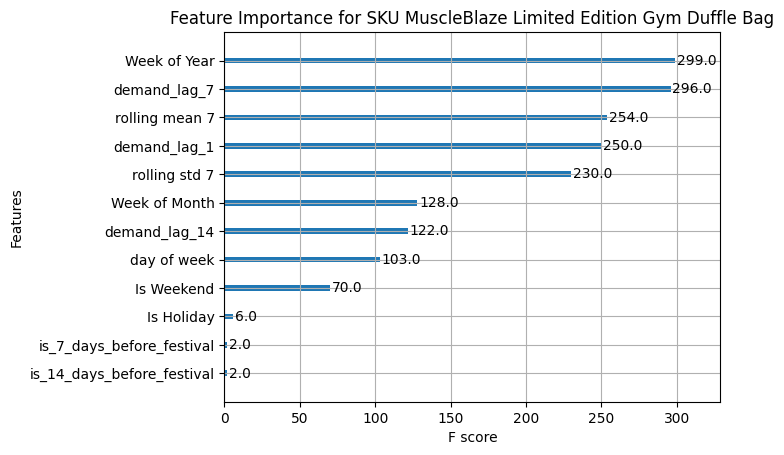

In [37]:
#plot output
plot_importance(model)
plt.title(f"Feature Importance for SKU {sku}")
plt.show()
 #Save the Results
results_df = pd.DataFrame.from_dict(results, orient='index')

# Export to Excel
results_df.to_excel('results.xlsx', index=True)

    

In [ ]:
combined_results = pd.DataFrame()
for sku, data in results.items():
    # Create a temporary DataFrame for the SKU
    temp_df = pd.DataFrame({
        'SKU': [sku] * len(results_df['predictions']),
        'Predictions': results_df['predictions'],
        'True_Values': results_df['true_values']
    })
    # Append the temporary DataFrame to the combined results
    combined_results = pd.concat([combined_results, temp_df], ignore_index=True)

# Export the results to Excel
#combined_results.to_excel('predictions_vs_true_values.xlsx', index=False)


In [213]:
y_pred

array([58.835308, 76.62409 , 79.20824 , 59.12928 , 70.514206, 78.31806 ,
       59.611412, 53.346073, 55.61179 , 60.657677, 58.402275, 54.14434 ,
       53.58444 , 59.562347, 66.615654, 58.442574, 65.50475 , 57.29801 ,
       62.238018, 80.35474 , 54.09472 , 57.98244 , 58.000896, 58.41942 ,
       47.71481 , 45.072346, 50.952114, 50.989086, 62.89821 , 71.45498 ,
       50.22448 , 46.71288 , 55.579475, 49.056644, 48.55887 , 52.62901 ],
      dtype=float32)

In [214]:
y_test

2663    83
2668    76
2677    60
2685    70
2690    77
2694    60
2702    70
2710    73
2721    67
2724    62
2734    55
2742    55
2748    46
2753    37
2758    56
2769    69
2774    64
2784    61
2787    80
2793    62
2801    60
2808    59
2816    53
2821    43
2827    63
2833    55
2841    60
2845    66
2851    66
2858    47
2863    49
2872    56
2879    46
2884    47
2891    39
2892    18
Name: Quantity, dtype: int64